In [173]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import SCORERS
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# Any results you write to the current directory are saved as output.

In [174]:
df = pd.read_csv('2015.csv')
df.columns = df.columns.str.strip()
df = df.drop(columns = ['Happiness Rank','Standard Error','Generosity','Country'])
one_hot = pd.get_dummies(df['Region'])
df = df.drop(columns = ['Region'])
hot_columns = list(one_hot.columns)
#df = df.join(one_hot)
#df.corr()['Happiness Score'].sort_values()
one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 10 columns):
Australia and New Zealand          158 non-null uint8
Central and Eastern Europe         158 non-null uint8
Eastern Asia                       158 non-null uint8
Latin America and Caribbean        158 non-null uint8
Middle East and Northern Africa    158 non-null uint8
North America                      158 non-null uint8
Southeastern Asia                  158 non-null uint8
Southern Asia                      158 non-null uint8
Sub-Saharan Africa                 158 non-null uint8
Western Europe                     158 non-null uint8
dtypes: uint8(10)
memory usage: 1.6 KB


In [ ]:
sns.pairplot(df)

In [175]:
Y = df['Happiness Score']
X = df.drop(columns = ['Happiness Score'])
backup_col = X.columns

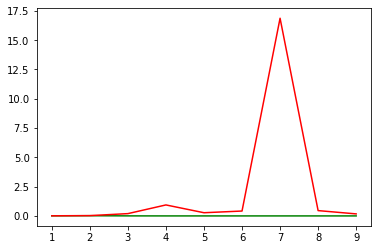

In [176]:
def split_scale(X,Y,hot_columns,one_hot,deg,isscale):
    poly = PolynomialFeatures(deg)
    poly.fit(X)
    tmp_X = pd.DataFrame(poly.transform(X))
    scale = StandardScaler()
    tmp_X = tmp_X.join(one_hot)

    X_train, X_test, Y_train, Y_test = train_test_split(tmp_X,Y,shuffle=True,test_size = 0.2)
    
    if isscale:
        X_train_num , X_train_cat = X_train.drop(columns = hot_columns), X_train[hot_columns]
        X_test_num , X_test_cat = X_test.drop(columns = hot_columns), X_test[hot_columns]
        scale.fit(X_train_num)
        X_train_num = pd.DataFrame(scale.transform(X_train_num),index = X_train_num.index,columns = X_train_num.columns)
        X_test_num = pd.DataFrame(scale.transform(X_test_num),index = X_test_num.index,columns = X_test_num.columns)
        X_train = X_train_num.join(X_train_cat)
        X_test = X_test_num.join(X_test_cat)
        
    return X_train, X_test, Y_train, Y_test
degree = 10
train_error = []
test_error = []

for deg in range(1,degree):
    X_train, X_test, Y_train, Y_test = split_scale(X,Y,hot_columns,one_hot,deg,True)
    model = LinearRegression()
    model.fit(X_train,Y_train)
    train_error.append(mean_squared_error(Y_train,model.predict(X_train)))
    test_error.append(mean_squared_error(Y_test,model.predict(X_test)))
#print(train_error,test_error)
plt.plot(np.arange(1,degree),train_error,color = "green")
plt.plot(np.arange(1,degree),test_error,color = "red")
#sorted(SCORERS.keys())
#X_train.head()
#X_train_num.info()

In [177]:
def adjust_rsq(r,n,p):
    return (1-((1-r)*(n-1))/(n-p-1))

model_std = make_pipeline(StandardScaler(),LinearRegression()) #StandardScaler + LinearRegression + Train_Test_split
X_train, X_test, Y_train, Y_test = split_scale(X,Y,hot_columns,one_hot,1,True)
model_std.fit(X_train,Y_train)
n,p = X_test.shape
print(model_std.score(X_test,Y_test))
print(adjust_rsq(model_std.score(X_test,Y_test),n,p))
print("######")

model = LinearRegression() # LinearRegression + Train_Test_split
X_train, X_test, Y_train, Y_test = split_scale(X,Y,hot_columns,one_hot,1,False)
model.fit(X_train,Y_train)
n,p = X_test.shape
print(model.score(X_test,Y_test))
print(adjust_rsq(model.score(X_test,Y_test),n,p))
print("######")

model_std_cv = RidgeCV(cv=10) #StandardScaler + RidgeRegression + Cros_validation
X_train, X_test, Y_train, Y_test = split_scale(X,Y,hot_columns,one_hot,1,True)
X_std_cv = pd.concat([X_train,X_test],ignore_index=True)
Y_std_cv = pd.concat([Y_train,Y_test],ignore_index=True)
model_std_cv.fit(X_std_cv,Y_std_cv)
n,p = X_std_cv.shape
print(model_std_cv.score(X_std_cv,Y_std_cv))
print(adjust_rsq(model_std_cv.score(X_std_cv,Y_std_cv),n,p))
print("######")

model_cv = RidgeCV(cv=10) #RidgeRegression + Cros_validation
X_train, X_test, Y_train, Y_test = split_scale(X,Y,hot_columns,one_hot,1,False)
X_cv = pd.concat([X_train,X_test],ignore_index=True)
Y_cv = pd.concat([Y_train,Y_test],ignore_index=True)
model_cv.fit(X_cv,Y_cv)
n,p = X_std_cv.shape
print(model_cv.score(X_cv,Y_cv))
print(adjust_rsq(model_cv.score(X_cv,Y_cv),n,p))

0.99087685186588
0.9797987434173058
######
0.9886900257216076
0.9749564855264168
######
0.9931031714522237
0.9922656994142794
######
0.9931203201266213
0.992284930427711


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [183]:
print(model_cv.alpha_)
print(model_cv.coef_)
print(X_cv.columns)
whole_col = list(backup_col) + hot_columns
print("The equation is :")
for a,x in zip(model_cv.coef_[1:],whole_col):
    print("{}*{}".format(a,x),end=' +')

0.1
[ 0.          0.87146014  1.06667957  1.02431386  1.10781774  1.07429688
  0.97263754  0.14234745 -0.12858044 -0.05823068 -0.07602947 -0.07403076
  0.15065718  0.09281311  0.03914818 -0.10896429  0.02086972]
Index([                                0,                                 1,
                                       2,                                 3,
                                       4,                                 5,
                                       6,       'Australia and New Zealand',
            'Central and Eastern Europe',                    'Eastern Asia',
           'Latin America and Caribbean', 'Middle East and Northern Africa',
                         'North America',               'Southeastern Asia',
                         'Southern Asia',              'Sub-Saharan Africa',
                        'Western Europe'],
      dtype='object')
The equation is :
0.8714601369469993*Economy (GDP per Capita)+1.0666795675394958*Family+1.0243138594973615*

The equation is :
$ 0.8714601369469993*x_{Economy (GDP per Capita)}+1.0666795675394958*x_{Family}+1.0243138594973615*x_{Health (Life Expectancy)}+1.107817744693976*x_{Freedom}+1.0742968799640424*x_{Trust (Government Corruption)}+0.9726375356499959*x_{Dystopia Residual}+0.14234745486417444*x_{Australia and New Zealand}-0.1285804353631947*x_{Central and Eastern Europe}+-0.05823067990265327*x_{Eastern Asia}-0.07602947095867327*x_{Latin America and Caribbean-0.07403076351430639*x_{Middle East and Northern Africa} +0.15065718114097487*North America+0.09281310714114879*x_{Southeastern Asia}+0.03914817899882089*x_{Southern Asia}-0.10896428772011527*x_{Sub-Saharan Africa}+0.02086971531384917*x_{Western Europe}$